In [3]:
import sys
sys.path.insert(0, "../scripts/")

from dataset import *
from evaluate import *

In [4]:
import pandas as pd
from pathlib import Path
import sys
import numpy as np

from sklearn import metrics

from tqdm import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
PATH_DATA = Path.home()/Path('code/microsoft-recommendation-contest/data/')
sys.path.append(str(PATH_DATA))

## Content

A few main modules.

- Load data
- Construct label dataset, containing two parts per sample
    - input: [],[] list of user historical news, list of news in impression
    - ouput: [] list of labels indicating which news are clicked (0/1) in the impression
- Model
    - Train (in word2vec approach, no need)
        - input: dataset
        - ouput: trained model, evaluation per epoch(optional), tensorboard data(optional)
    - Evaluate
        - input: dataset
        - ouput: all 4 scores
    - Inference
        - input: dataset
        - ouput: ranked recommendation result as of required format

## Load data

In [6]:
behaviors_train, news_train = load_data('MINDsmall_train')
behaviors_val, news_val = load_data('MINDsmall_dev')

../data/MINDsmall_train/behaviors.tsv, data shape: (156965, 5)
../data/MINDsmall_train/news.tsv, data shape: (51282, 8)
../data/MINDsmall_dev/behaviors.tsv, data shape: (73152, 5)
../data/MINDsmall_dev/news.tsv, data shape: (42416, 8)


In [7]:
# sel columns 
news_col_sel = ['news_id','title','abstract']
behaviors_col_sel = ['impression_id','user_id','history','impressions']

news_train = news_train[news_col_sel]
news_val = news_val[news_col_sel]
behaviors_train = behaviors_train[behaviors_col_sel]
behaviors_val = behaviors_val[behaviors_col_sel]

In [8]:
behaviors_train.sample(1)

,impression_id,user_id,history,impressions
66627,66628,U37993,N39235 N55951 N9226 N52536 N26176 N30698 N619 ...,N41020-0 N20069-0 N7319-0 N31947-0 N49180-0 N1...


In [9]:
news_train.sample(1)

,news_id,title,abstract
10256,N19101,Couple who met on Tinder get engaged using a r...,"James Lawrence, 24, and Hayley Orchard, 26, fr..."


## Generate News Embedding

Embedding can be created in various ways.
1. pooling of word embedding <- use this one in this notebook
2. news title+abstract embedding based on language model
3. end-to-end trained from network
4. from graph relation
5. entity embedding provided
6. mixed

In [10]:
glove_embedding_file = '../data/glove.6B/glove.6B.50d.txt'

In [11]:
embedding, word_ind  = load_w2v_from_file(glove_embedding_file, dim_size=None)

In [12]:
news_train.head(3)

,news_id,title,abstract
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...


In [13]:
def news_emb_gen_from_df(news_df, embedding, word_ind):
    """
    create news embedding from a dataframe
    return a dictionary whose key is news id and value is a vector
    """
    result = {}
      
    for _,row in news_df.iterrows():
        
        vec = np.array([embedding[word_ind.get(x,0)] for x in row[TITLE].split()])
        result[row[NEWS_ID]]=np.mean(vec, axis=0)
    
    return result

# function test
# process_emb_df(df_emb, dim_size=None)

In [14]:
%time
news_2_vec = news_emb_gen_from_df(pd.concat([news_train, news_val]), embedding, word_ind)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [35]:
def build_news_embedding(news_2_vec):
    emb = []
    news_2_index = dict() # index starts from 1, reserve 0 for padding
    
    for i, news_id in enumerate(news_2_vec):
        news_2_index[news_id] = i+1
        emb.append(torch.tensor(news_2_vec[news_id]))
    
    emb.insert(0, torch.randn(len(emb[0])))  # insert a randomized embedding for padding
    weight = torch.stack(emb)
#     embedding = nn.Embedding.from_pretrained(weight, freeze=True)
    
    return weight, news_2_index

In [43]:
news_embedding, news_2_index = build_news_embedding(news_2_vec)

In [41]:
len(news_2_index)

65238

In [15]:
len(news_2_vec)

65238

## Construct Dataset

- Construct label dataset, containing two parts per sample
    - input: [],[] list of user historical news, list of news in impression
    - ouput: [] list of labels indicating which news are clicked (0/1) in the impression

Build Dataset and DataLoader

In [26]:
class BehaviorDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, behavior_df, mode = 'train'):
        """
        Initialization
        mode: train, eval, inference
        """
        self.df = behavior_df
        self.mode = mode

    def __len__(self):
        'Denotes the total number of samples'
        return self.df.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        r = self.df.iloc[index]

        # Load data and get label
        history = r['history'].split()
        if self.mode in ('train','eval'):
            impressions = [x.split('-')[0] for x in r['impressions'].split(' ')]
            labels = [int(x[-1]) for x in r['impressions'].split(' ')]
        else:
            impressions = [x for x in r['impressions'].split(' ')]
            labels = None

        return (history,impressions,labels)

In [27]:
train_ds = BehaviorDataset(behaviors_train)

In [47]:
def collate_batch(batch):
    # because there is no paddng, so only support batch size =1 
    history_list, impressions_list, label_list = [], [], []
    for history,impressions,labels in batch:
        history_list.append([news_2_index.get(news_id, 0) for news_id in history])
        impressions_list.append([news_2_index.get(news_id, 0) for news_id in impressions])
        label_list.append(labels)
        
    history_list = torch.tensor(history_list, dtype=torch.int64)
    impressions_list = torch.tensor(impressions_list, dtype=torch.int64)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    
    return history_list.to(device), impressions_list.to(device), label_list.to(device)

In [48]:
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=1, 
    shuffle=False, num_workers=0, collate_fn=collate_batch)

## Generate user embedding

Embedding can be created in various ways.
1. pooling of news embedding
3. end-to-end trained model
4. from graph relation

In [14]:
def user_emb_gen_from_pooling(behavior_df, news_2_vec):
    """
    create user embedding by the pooling of its corresponding news embedding
    return a dictionary whose key is user id and value is a vector
    """
    behavior_df['history'].fillna('',inplace=True)
    
    result = {}
    for _,row in behavior_df.iterrows():
        if len(row['history'])>0:
            vec = np.array([news_2_vec.get(news_id) for news_id in row['history'].split()] )
            vec = np.mean(vec,axis=0)
            result[row[USER_ID]] = vec

    return result

In [68]:
%time
user_2_vec = user_emb_gen_from_pooling(pd.concat([behaviors_train, behaviors_val]), news_2_vec)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


/home/alchemist/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [16]:
# def user_emb_gen_from_pooling(behavior_df, news_2_vec):
#     """
#     create user embedding by the pooling of its corresponding news embedding
#     return nn.Embedding instance and word_to_index dictionary
#     """
    
#     vocab = []
#     emb = []
    
#     for _,row in behavior_df.iterrows():
#         lookup_list = [news_2_vec.get(news_id) for news_id in row['history'].split()]
#         lookup_tensor = torch.tensor(lookup_list, dtype=torch.long)
#         vec = torch.mean(news_emb(lookup_tensor),axis=0).squeeze()
#         print(vec.size())
        
#         vocab.append(row['user_id'])
#         emb.append(vec)
    
#     print(emb)
#     emb.insert(0, torch.randn(len(vec)))  # insert a randomized embedding for padding
#     weight = torch.stack(emb)
#     embedding = nn.Embedding.from_pretrained(weight, freeze=True)
    
#     word_ind = {w:i+1 for i,w in enumerate(vocab)}  # index starts from 1, reserve 0 for padding
    
#     return embedding, word_ind 

In [69]:
# # test function
# user_emb, user_word_index = user_emb_gen_from_pooling(None, news_emb, news_word_index, behaviors_train.head(3))

## Predict

In [16]:
behaviors_val.head()

,impression_id,user_id,history,impressions
0,1,U80234,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...


prepare labelled data

In [17]:
def cosine_sim(user_v,news_v):
    return np.dot(user_v, news_v)/(np.linalg.norm(user_v)*np.linalg.norm(news_v))

In [51]:
np.zeros(3)

array([0., 0., 0.])

In [53]:
def get_label_from_behavior(df):
#     df['is_clicked'] =
    return df['impressions'].apply(lambda s: [int(x[-1]) for x in s.split(' ')])


def predict_from_behavior(df):
    def _calculate_relevence(r):
        news = [x.split('-')[0] for x in r['impressions'].split(' ')]
        global news_2_vec, user_2_vec
        
        # if user id is not calculated, pad 0 as relevence
        if r['user_id'] not in user_2_vec:
            return np.zeros(len(news))
        
        # construct similarity
        user_v = user_2_vec.get(r['user_id'])
        relevence = [cosine_sim(news_2_vec.get(news_id),user_v) if news_id in news_2_vec else 0 for news_id in news ]
        
        rank = np.argsort(np.argsort(relevence)[::-1]) + 1  # really trick i would say. check https://github.com/numpy/numpy/issues/8757
        return 1./rank
    return df.progress_apply(_calculate_relevence, axis=1)
  

In [53]:
# calculate predictions
behaviors_train['is_clicked_pred'] = predict_from_behavior(behaviors_train)

100%|██████████| 156965/156965 [01:16<00:00, 2057.80it/s]


In [54]:
behaviors_train['is_clicked'] = get_label_from_behavior(behaviors_train)

In [55]:
behaviors_train.sample(3)

,impression_id,user_id,history,impressions,is_clicked_pred,is_clicked
84752,84753,U10353,N50710,N35729-0 N62729-1,"[1.0, 0.5]","[0, 1]"
83715,83716,U67766,N60844 N50578 N51706 N995 N36053 N20710 N44361...,N62729-0 N35729-1 N27581-0 N12042-0 N31273-0 N...,"[0.25, 1.0, 0.5, 0.14285714285714285, 0.333333...","[0, 1, 0, 0, 0, 0, 0]"
92670,92671,U74854,N16870 N17919 N30157 N50028 N8851 N43734 N1844...,N2869-0 N58499-0 N40539-0 N37199-0 N11768-0 N1...,"[0.011235955056179775, 0.012658227848101266, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [57]:
scoring_from_relevence(behaviors_train['is_clicked'], behaviors_train['is_clicked_pred'])

AUC:0.5235
MRR:0.2393
nDCG@5:0.2469
nDCG@10:0.3044


(0.5235014074598069,
 0.2392946769528863,
 0.24694093432823816,
 0.3043782717134491)

In [60]:
# empty user embedding is only a small portion
behaviors_train[behaviors_train['is_clicked_pred'].apply(sum)==0].shape

(3238, 6)

In [61]:
behaviors_train.shape

(156965, 6)

In [70]:
# calculate predictions
behaviors_val['is_clicked_pred'] = predict_from_behavior(behaviors_val)
behaviors_val['is_clicked'] = get_label_from_behavior(behaviors_val)

100%|██████████| 73152/73152 [00:35<00:00, 2050.41it/s]


In [72]:
group_auc = behaviors_val.progress_apply(lambda r: roc_auc_score(r['is_clicked'],r['is_clicked_pred']), axis=1).mean()
print(group_auc)

100%|██████████| 73152/73152 [00:45<00:00, 1606.28it/s]

0.5159025327192664


In [35]:
def generate_pred_dataset(df, is_test=False):
    """df: user bahaviour df"""
    df['impression'] = df['impressions'].apply(lambda x: [y for y in x.split()])
    df_pred = df[['user_id','impression']].explode('impression')
    df_pred['news_id'] = df_pred['impression'].apply(lambda x: x.split('-')[0])
    
    if not is_test:
        df_pred['label'] = df_pred['impression'].apply(lambda x: x.split('-')[1]).astype(np.uint8)
    
    return df_pred

In [52]:
df2 = generate_pred_dataset(behaviors_train)

In [53]:
df2.head()

,user_id,impression,news_id,label
0,U13740,N55689-1,N55689,1
0,U13740,N35729-0,N35729,0
1,U91836,N20678-0,N20678,0
1,U91836,N39317-0,N39317,0
1,U91836,N58114-0,N58114,0


In [55]:
def evaluate(r):
    user_v = user_2_vec.get(r[USER_ID], None)
    news_v = news_2_vec.get(r[NEWS_ID], None)
    
    if user_v is not None and news_v is not None:
        return np.dot(user_v, news_v)/(np.linalg.norm(user_v)*np.linalg.norm(news_v))
    else:
        return 0

In [56]:
y_pred = df2.progress_apply(evaluate,axis=1)

100%|██████████| 5843444/5843444 [03:22<00:00, 28812.19it/s]


In [68]:
max(y_pred)

1.0000001192092896

In [ ]:
(y_pred.values+1)/2

In [73]:
import seaborn as sns


/home/alchemist/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


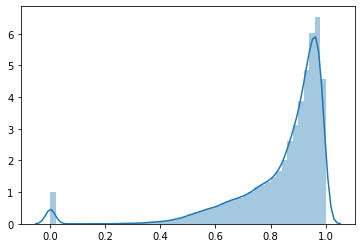

In [74]:
sns.distplot(y_pred.sample(100000))

In [69]:
fpr, tpr, thresholds = metrics.roc_curve(df2[LABEL].values,(y_pred.values+1)/2,pos_label=1)

In [70]:
metrics.auc(fpr, tpr)

0.5145798938358582

In [71]:
from matplotlib import pyplot as plt
%matplotlib inline

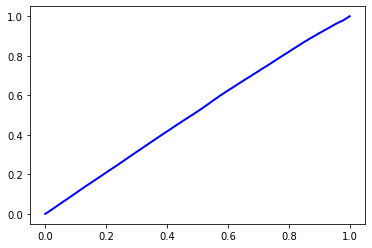

In [72]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='b', lw=2)
plt.show()

The result is no better than random guess. Need to validate the news vector. To see if closet vectors are making sense.

In [30]:
def count_click(impressions):
    return sum([int(x[-1]) for x in impressions.split(' ')])

In [31]:
behaviors_val['impressions'].apply(count_click)

0        1
1        1
2        1
3        1
4        2
        ..
73147    9
73148    1
73149    2
73150    1
73151    1
Name: impressions, Length: 73152, dtype: int64

In [77]:
news_val.head()

,news_id,title,abstract
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N18955,Dispose of unwanted prescription drugs during ...,NaN
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


In [ ]:
def predict(pred_net, user_emb, news_emb, pred_dataset):
    """
    generate a score between (0-1) on whether this news should be recommmended to this user
    
    pred_dataset: two values per instance, user_id and news_id
    """
    